# Assignment 3: Image Colourization [50 Pt]

In this assignment, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebook, and should download automatically the first time it is loaded.

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.

*This assignment is based on an assignment developed by Prof. Lisa Zhang and Prof. Jimmy Ba.*

### What to submit

1. Submit the .ipynb and html files containing all your code, outputs, and write-up from parts A and B. Please take extra effort to make your answers and submissions readable. Do not display unnecessary outputs, only the ones that are important for supporting your answers.

  You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.


2. Colourized images produced by your best model from the provided dataset of grayscale images in Part B.2 saved as "colourized.npz".

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [4]:
# TO BE COMPLETED
# https://colab.research.google.com/drive/1AHi2FY2MokxDCEOaTX0OBgk-vJR6C2p_#scrollTo=zbnrp2ig1pps

# PART A - Autoencoder
In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [5]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import logging
# prevent warning messages
logging.getLogger('matplotlib.image').setLevel(logging.ERROR)


In [6]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [7]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    """
    Responsible for downloading a file from given URL and extracting it if needed.
    :param fname: filename to save as
    :param origin: original URL of
    :param untar: If true, extract .tar.gz files
    :param extract: If true, extract .tar files
    :param archive_format: one of "auto", "tar", "zip"
    :param cache_dir: directory to save data to
    """
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [8]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


In [9]:
m[0][0].shape

(50000, 3, 32, 32)

## Part 1 Data Preparation [5 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks.

### Part (i) [2pt EXPLORATORY]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [10]:
# TO BE COMPLETED

# Check the shape of each X_train, y_train, X_test, y_test
print("Training Dataset")
print(m[0][0].shape)
print(m[0][1].shape)
print("\nTesting Dataset")
print(m[1][0].shape)
print(m[1][1].shape)






Training Dataset
(50000, 3, 32, 32)
(50000, 1)

Testing Dataset
(10000, 3, 32, 32)
(10000, 1)


In [11]:
'''
PROVIDE YOUR ANSWER BELOW

How many samples?
- 50,000 samples in the training set
- 10,000 samples in the testing set

How is the data organized?

Images
- (num_samples, 3, 32, 32)
- num_samples: Number of images (50,000 for training, 10,000 for testing)
- 3: RGB channels
- 32x32: Image size

Labels
- (num_samples, 1)
- num_samples: Number of images (50,000 for training, 10,000 for testing)
- 1: Label (0-9)

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nHow many samples?\n- 50,000 samples in the training set\n- 10,000 samples in the testing set\n\nHow is the data organized?\n\nImages\n- (num_samples, 3, 32, 32)\n- num_samples: Number of images (50,000 for training, 10,000 for testing)\n- 3: RGB channels\n- 32x32: Image size\n\nLabels\n- (num_samples, 1)\n- num_samples: Number of images (50,000 for training, 10,000 for testing)\n- 1: Label (0-9)\n\n'

### Part (ii) [3pt EXPLORATORY]

Provided below is sample code to preproces the data to select only images of horses, which will help to simplify the goals of the assignment. The function also converts the colour images to greyscale to create our input data.

In [12]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :] #Pick all the HORSE
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True) #Average across each channels

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


The provided get_batch function creates a dataloader (or function) to batch the samples.

In [13]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)


Run the above helper code and call the appropriate fucntion to verify and visualize that we are able to generate different batches of data with the correct class of images (i.e., horses).

Write code to visualize 5 train and test (validation) images.

In [14]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [15]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [16]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [17]:
# TO BE COMPLETED

# Input (x): Grey, Output (y): RGB
train_generator = get_batch(train_grey, train_rgb, 1)
test_generator = get_batch(test_grey, test_rgb, 1)




Write code to visualize 5 train/test images

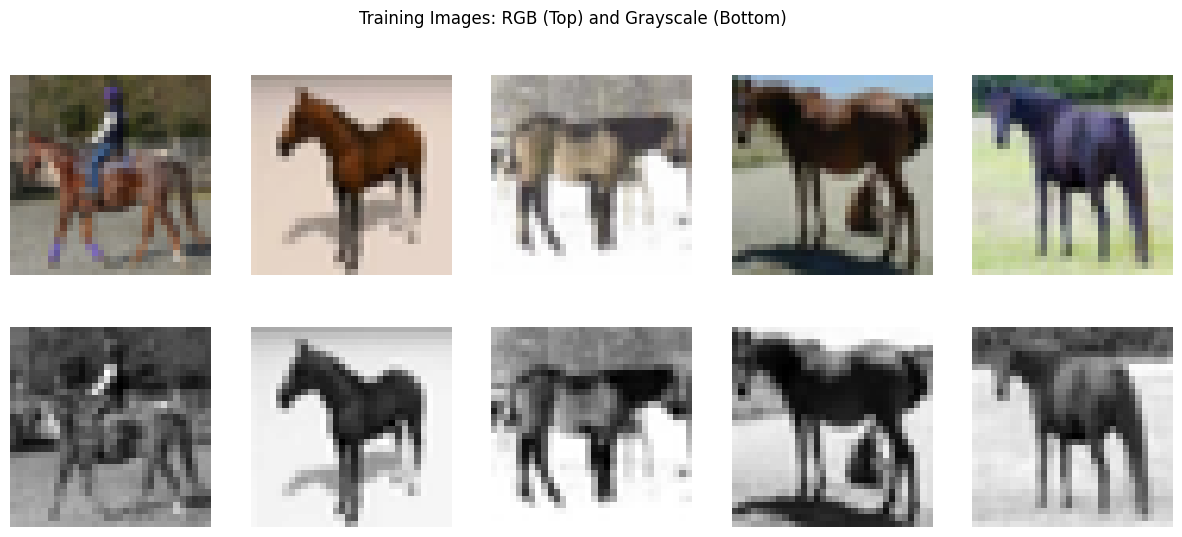

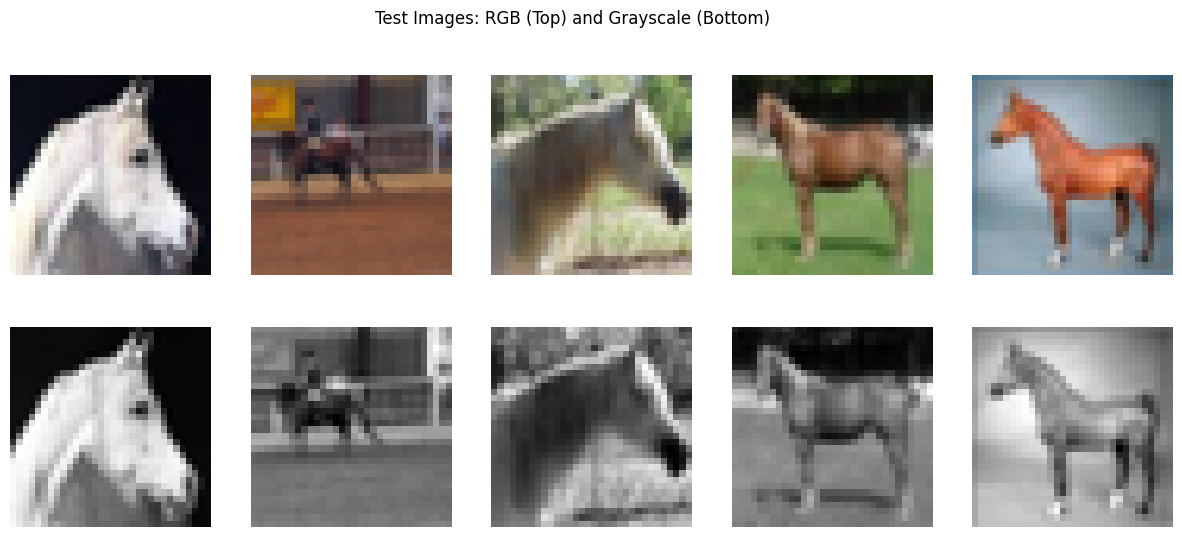

In [18]:
# TO BE COMPLETED
import numpy as np
import matplotlib.pyplot as plt

num_images = 5  # Number of images to display

fig, axes = plt.subplots(2, num_images, figsize=(15, 6))  # 2 rows: RGB + Grayscale

# Plot training images
for i in range(num_images):
    batch_x, batch_y = next(train_generator)
    rgb_image = batch_y[0].transpose(1, 2, 0)
    gray_image = batch_x[0].squeeze() #Shape (32,32)

    axes[0, i].imshow(rgb_image)  # RGB Image
    axes[0, i].axis("off")

    axes[1, i].imshow(gray_image, cmap="gray")  # Grayscale Image
    axes[1, i].axis("off")

fig.suptitle("Training Images: RGB (Top) and Grayscale (Bottom)")

plt.show()
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))  # 2 rows: RGB + Grayscale

for i in range(num_images):
    batch_x, batch_y = next(test_generator)
    rgb_image = batch_y[0].transpose(1, 2, 0)
    gray_image = batch_x[0].squeeze()

    axes[0, i].imshow(rgb_image)  # RGB Image
    axes[0, i].axis("off")

    axes[1, i].imshow(gray_image, cmap="gray")  # Grayscale Image
    axes[1, i].axis("off")

fig.suptitle("Test Images: RGB (Top) and Grayscale (Bottom)")

plt.show()







## Part 2 Image Colourization as Regression [8 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will be the training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [19]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),) #This is only needed since we are using normal convolution layer in this case. Normally we could just use ConvTranspose2d
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),) #Double the height and width
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [20]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        if args.plot and epoch % 5 ==0 :
          print(epoch, loss.cpu().detach())
          visual(images, labels, outputs, args.gpu, 1)

        # Append the training loss
        avg_epoch_loss = sum(losses) / len(losses)
        train_losses.append(avg_epoch_loss)  # ✅ Store only one value per epoch

    # Visualize the training curve for part 3
    if args.visualize: # Plot training curve
        plt.figure()
        plt.plot(train_losses)
        plt.legend(['Train'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    return gen

Training visualization code

In [21]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu: #If True, moves data from GPU to CPU
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch: #If True, converts PyTorch tensors to Numpy arrays
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure # matplitlib.imshow() expects (H,W,C)
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

In [22]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 51,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

### Part (i) [3pt EXPLORATORY]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer?

In [23]:
'''
PROVIDE YOUR ANSWER BELOW

Number of Convolution Layers
1. 2 in Downsampling Layers
2. 1 in Bottleneck
3. 2 in Upsampling Layer
4. 1 in the Final Output

Filter Sizes and Number of Filters
1. Downconv1: 3x3, 32 filters
2. Downconv2: 3x3, 64 filters
3. RFConv: 3x3, 64 filters
4. Upconv1: 3x3, 32 filters
5. Upconv2: 3x3, 3 filters
6. FinalConv: 3x3, 3 filters



'''

'\nPROVIDE YOUR ANSWER BELOW\n\nNumber of Convolution Layers\n1. 2 in Downsampling Layers\n2. 1 in Bottleneck\n3. 2 in Upsampling Layer\n4. 1 in the Final Output\n\nFilter Sizes and Number of Filters\n1. Downconv1: 3x3, 32 filters\n2. Downconv2: 3x3, 64 filters\n3. RFConv: 3x3, 64 filters\n4. Upconv1: 3x3, 32 filters\n5. Upconv2: 3x3, 3 filters\n6. FinalConv: 3x3, 3 filters\n\n\n\n'

### Part (ii) [2pt EXPLORATORY]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting?

In [24]:
# TO BE COMPLETED
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
'''
PROVIDE YOUR ANSWER BELOW

Since the model is reinitialized everytime calling the training function, the weights are reinitialized.

Given the args settings, the model is trained for 51 epochs.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nSince the model is reinitialized everytime calling the training function, the weights are reinitialized.\n\nGiven the args settings, the model is trained for 51 epochs.\n\n'

### Part (iii) [1pt RESULTS]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

In [26]:
# TO BE COMPLETED

# Try (10: Underfitting, 30: Moderate training, 100: Overfitting)

for epochs in [10, 30, 100]:
  args.epochs = epochs

  print(f"Training model with {epochs} epochs")

  cnn = train(args)



Output hidden; open in https://colab.research.google.com to view.

In [27]:
'''
PROVIDE YOUR ANSWER BELOW

10 epochs:
- Output Image: Blury, not well-trained
- Training Loss: 0.0133

30 epochs:
- Output Image: Clearer, Better generalization
- Training Loss: 0.0094

100 epochs:
- Output Image: Even sharper. But there is only a small improvement in details and color quality compared to 30 epochs.
  - The model may have already learned most of the meaningful pastterns by 30 epochs
- Training Loss: 0.0057

'''

'\nPROVIDE YOUR ANSWER BELOW\n\n10 epochs:\n- Output Image: Blury, not well-trained\n- Training Loss: 0.0133\n\n30 epochs:\n- Output Image: Clearer, Better generalization\n- Training Loss: 0.0094\n\n100 epochs:\n- Output Image: Even sharper. But there is only a small improvement in details and color quality compared to 30 epochs.\n  - The model may have already learned most of the meaningful pastterns by 30 epochs\n- Training Loss: 0.0057\n\n'

### Part (iv) [2pt MODEL]

Modify the autoencoder archeticture to use transposed convolution layers for the decoder portion. Ensure that the appropriate parameters are modified (e.g. input and output channels, padding) to accommodate this change. Train your model and present your best results. Hint1: Please check Pre3A_Autoencoder.ipynb for examples on how to use transposed convolution layers. Hint2: the output dimensions of upconv1 when using ConvTranspose2d for example should match the output of upconv1 when using Conv2d.

In [28]:
# TO BE COMPLETED
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters): #Current setting, kernel = 3, num_filters = 32
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        # TO BE COMPLETED
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding, stride=2, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        # TO BE COMPLETED
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, 3, kernel_size=kernel, padding=padding, stride=2, output_padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
        )

        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

In [29]:
# Train the model using the same configuration
args.epochs = 51
args.visualize = False #No Plotting Training Curve
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
'''
PROVIDE YOUR ANSWER BELOW

The Transpose Convolution is added in the upsampling process with the argument (stride=2, output_padding=1). The (Kernel Size, Padding) should match the corresponding Convolution Layer.

Difference between ConvTranspose2d and UpSample(2):
- ConvTranpose2d learns how to unsample with tunable parameters (Kernels)
- UpSample: ONly interpolates existing pixels

Results:
- ConvTranspose2d produces sharper images
- ConvTranspose2d learns how to upsample effectively instead of just interplating.
- The loss is much lower than the previous model. (0.0039 (ConvTranspose2d) vs. 0.0071 (UpSample))

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nThe Transpose Convolution is added in the upsampling process with the argument (stride=2, output_padding=1). The (Kernel Size, Padding) should match the corresponding Convolution Layer.\n\nDifference between ConvTranspose2d and UpSample(2):\n- ConvTranpose2d learns how to unsample with tunable parameters (Kernels)\n- UpSample: ONly interpolates existing pixels\n\nResults:\n- ConvTranspose2d produces sharper images\n- ConvTranspose2d learns how to upsample effectively instead of just interplating.\n- The loss is much lower than the previous model. (0.0039 (ConvTranspose2d) vs. 0.0071 (UpSample))\n\n'

## Part 3 Skip Connections [5 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. In this section we will be incorporating skip connections to improve on our model architecture.

### Part (i) [2pt MODEL]
In this task, modify the original RegressionCNN class to implement a U-Net architecture by adding skip connections between the corresponding layers in the encoder and decoder (i.e., Add a skip connection from the first layer to the last, second layer to the second last, etc.). Specifically, the output of each downsampling block should be concatenated with the output of the corresponding upsampling block. For example, the input to upconv1 should be the concatenation of the output of rfconv and the output of downconv2. You will need to use torch.cat() to concatenate the feature maps along the channel dimension. Ensure the channel dimensions match after concatenation, possibly by adjusting the number of filters where necessary. The final convolution should have both the output of the previous layer and the initial greyscale input as input. Please complete the __init__ and forward methods of the UNet class below.
Hint: You will not need to update the downsampling part but you would need to update upsampling part and the final layer.

In [31]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())


        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*3, num_filters, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )

        self.finalconv = nn.Conv2d(num_filters+1, 3, kernel_size=kernel, padding=padding)



    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        out_down1 = self.downconv1(x)
        out_down2 = self.downconv2(out_down1)
        out_middle = self.rfconv(out_down2)

        # Input for Upsample 1 (C,H,W) = (128,8,8)
        out_middle = torch.cat((out_middle, out_down2), dim=1)
        out_up1 = self.upconv1(out_middle)

        # Input for Upsample 2 (C,H,W) = (64,16,16)
        out_up1 = torch.cat((out_up1, out_down1), dim=1)

        out_up2 = self.upconv2(out_up1)

        out = torch.cat((out_up2, x), dim=1)
        out = self.finalconv(out)
        return out

### Part (ii) [2pt RESULTS]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100. You might want to update the train function to plot the training curve.

In [32]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 51,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": True, #For Trainig Curve
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

How does the result compare to the previous model? Did skip connections improve the loss? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

In [33]:
'''
Compare the results:
- Skip connections: Clearer Image. Cleaner Background. Loss: 0.0037
- Normal Encoder: Blurrier Image. Blurrier Background. Loss: 0.0039

Did skip connections improve the loss?
- Yes. Improve by 0.0002

Did the skip connections improve the output qualitatively.
- Yes. The background of the image is less blurrier than the normal encoder

Two reasons why skip connections might improve the performance of our CNN models.
1. Improved Gradient Flow by preventing vanishing gradients
2. Preserving High-Frequency Details. Downsampling reduce spatial resolution (Pooling Layer) --> Skip connections restore these details by bringing back high-resolution features from earlier layers.






'''

'\nCompare the results:\n- Skip connections: Clearer Image. Cleaner Background. Loss: 0.0037\n- Normal Encoder: Blurrier Image. Blurrier Background. Loss: 0.0039\n\nDid skip connections improve the loss?\n- Yes. Improve by 0.0002\n\nDid the skip connections improve the output qualitatively.\n- Yes. The background of the image is less blurrier than the normal encoder\n\nTwo reasons why skip connections might improve the performance of our CNN models.\n1. Improved Gradient Flow by preventing vanishing gradients\n2. Preserving High-Frequency Details. Downsampling reduce spatial resolution (Pooling Layer) --> Skip connections restore these details by bringing back high-resolution features from earlier layers.\n\n\n\n\n\n\n'

### Part (iii) [1pt RESULTS]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs.

In [34]:
# TO BE COMPLETED

# Try three different mini batch sizes: 128, 256, 512

for batch_size in [128, 256, 512]:
  args.batch_size = batch_size
  args.visualize = True #For Trainig Curve
  print(f"Training model with {batch_size} epochs")
  cnn = train(args)





Output hidden; open in https://colab.research.google.com to view.

Describe the effect of batch sizes on the loss and the final image output.

In [35]:
'''
Batch Size = 128
- Lowest Final Loss: 0.0017
- Sharpest output images with well-preserved details
- The model benefits from a good balance of gradient noise and stability, leading to strong generalization and effective learning

Batch Size = 256
- Larger Batch Size leading to more stable gradient update but possibly less adaptable.
- Small drop in quality

Batch Size = 512
- Highest final loss: 0.0042
- The ouput images are noticably blurrier, with weaker details and color accuracy
- Lower gradient variance, making update less flexible and potentially stuck in sharp minima, leading to poorer generalization

'''

'\nBatch Size = 128\n- Lowest Final Loss: 0.0017\n- Sharpest output images with well-preserved details\n- The model benefits from a good balance of gradient noise and stability, leading to strong generalization and effective learning\n\nBatch Size = 256\n- Larger Batch Size leading to more stable gradient update but possibly less adaptable.\n- Small drop in quality\n\nBatch Size = 512\n- Highest final loss: 0.0042\n- The ouput images are noticably blurrier, with weaker details and color accuracy\n- Lower gradient variance, making update less flexible and potentially stuck in sharp minima, leading to poorer generalization\n\n'

# PART B - Conditional GAN

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task. This second half of the assignment should be started after the lecture on generative adversarial networks (GANs).

## Part 1 Conditional GAN [9 Pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. Later you will have the opportunity to explore other modifications that can be made to our architecture to achieve the best results on image colourization model.


### Part (i) [2pt MODEL]
Modify the below code to implement a generator. Then test to verify it works on the desired input (e.g., you could pass few inputs to your generator to verify it works with no errors). You should reuse one of your earlier autoencoder models from Part A here to act as a generator, if you do so, the architecture will be more like the pix2pix architecture (see https://phillipi.github.io/pix2pix/ for more details).

In [36]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())


        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*3, num_filters, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )

        self.finalconv = nn.Conv2d(num_filters+1, 3, kernel_size=kernel, padding=padding)



    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        out_down1 = self.downconv1(x)
        out_down2 = self.downconv2(out_down1)
        out_middle = self.rfconv(out_down2)

        # Input for Upsample 1 (C,H,W) = (128,8,8)
        out_middle = torch.cat((out_middle, out_down2), dim=1)
        out_up1 = self.upconv1(out_middle)

        # Input for Upsample 2 (C,H,W) = (64,16,16)
        out_up1 = torch.cat((out_up1, out_down1), dim=1)

        out_up2 = self.upconv2(out_up1)

        out = torch.cat((out_up2, x), dim=1)
        out = F.tanh(self.finalconv(out))
        return out

Write code to test that the generator works as intended. No training is needed—simply pass random inputs to the generator to ensure it functions correctly and that the output shapes match your expectations.

torch.Size([1, 3, 32, 32])


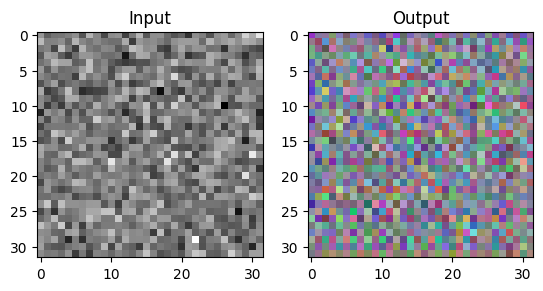

In [37]:
# TO BE COMPLETED

# Pass in Random input to the generator and visualize
random_input = torch.randn(1,1,32,32)
generator = Generator(3, 32)
output = generator(random_input)
print(output.shape)


fig, axes = plt.subplots(1, 2)

# Visualize the input
axes[0].imshow(random_input.squeeze(), cmap="gray")
axes[0].set_title('Input')

# Visualize the output
# Move back to range [0,1]
output = (output+1)/2
axes[1].imshow(output.squeeze().permute(1, 2, 0).detach().numpy())
axes[1].set_title('Output')

plt.show()



### Part (ii) [2pt MODEL]
Modify the below code to implement a discriminator. Then test to verify it works on the desired input (e.g., you could pass few inputs to your discriminator to verify it works with no errors).

You should build a simple CNN model to act as a discriminator for real and fake images. Your discriminator should have few convolutional layers followed by a fully connected network for classification.

In [38]:
# discriminator code

class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.num_filters = num_filters

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        # A simple convolution then a binary classifier
        self.conv1 = nn.Sequential(
            # The input is 4 channels (Gray Scale (Condition) + Color (Real or Fake))
            nn.Conv2d(4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2))

        # Classification
        self.fc = nn.Sequential(
            nn.Linear(num_filters*4*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            # nn.Sigmoid() #Real or Fake
        )



    def forward(self, x, img_greyscale):

        ############### YOUR CODE GOES HERE ###############
        ###################################################

        #img_greyscale: Condition, x: Real or fake
        out = torch.cat((img_greyscale, x), dim=1) #Concatenate along the channels dimension
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)

        out = out.view(out.shape[0], -1)
        out = self.fc(out)


        return out

Write code to test that the discriminator is working as intended. No training is needed—simply pass random inputs to the discriminator to ensure it functions correctly and that the output shapes match your expectations.

In [39]:
# TO BE COMPLETED
random_input = torch.randn(1,3,32,32) #Color Image
random_condition = torch.randn(1,1,32,32) #Condition Grey Scale Image
discriminator = Discriminator(3, 32)
output = discriminator(random_input, random_condition)
print(output.shape)
print(output)


torch.Size([1, 1])
tensor([[-0.0582]], grad_fn=<AddmmBackward0>)


### Part (iii) [2pt MODEL]
Modify the provided training code to implement the training needed for a conditional GAN.

In [70]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float() #--> ADDED for cGAN
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES

    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
        # Net = globals()[args.model]
        generator_class = globals()[args.model[0]]
        discriminator_class = globals()[args.model[1]]

        cnn = generator_class(args.kernel, args.num_filters)
        discriminator =discriminator_class(args.kernel, args.num_filters)


    # LOSS FUNCTION

    criterion = nn.BCEWithLogitsLoss()
    g_optimizer = torch.optim.Adam(cnn.parameters(), args.learn_rate)
    d_optimizer =torch.optim.Adam(discriminator.parameters(), args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()
        discriminator.train()
        losses = []

        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)

            #--->ADDED 5
            img_grey = images
            img_real = labels
            batch_size = args.batch_size

            # Rescale images to range -1 to 1 since the output of the generator has activation function tanh
            img_real = img_real * 2 - 1

            #discriminator training

            d_optimizer.zero_grad()

            # Discriminator losses on real images (Class 0)
            d_real = discriminator(img_real, img_grey)
            d_real_loss = criterion(d_real, torch.zeros(args.batch_size,1).to(images.device))

            # Discriminator losses on fake images (Class 1)
            d_fake = discriminator(cnn(img_grey), img_grey)
            d_fake_loss = criterion(d_fake, torch.ones(args.batch_size,1).to(images.device))

            # Add up losses
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()

            # generator training
            g_optimizer.zero_grad()

            # generator losses on fake images
            g_fake = discriminator(cnn(img_grey), img_grey)
            g_loss = criterion(g_fake, torch.zeros(args.batch_size,1).to(images.device)) #Want to encourage the discriminator to classify fake images as real

            g_loss.backward()
            g_optimizer.step()

            losses.append((d_loss.item(), g_loss.item()))

        # Add checkpoint
        checkpoint_path = f"outputs/colourization_cnn/GANs/bs_{args.batch_size}_lr{args.learn_rate}_epoch_{epoch}"
        # Save the generator model
        torch.save(cnn.state_dict(), checkpoint_path)

        # print and visualize
        loss = np.mean(losses, axis=0)
        outputs = (cnn(images)+1)/2 #This transform back to range [0,1] for visualization
        img_real = (img_real+1)/2 #This transform the back to range [0,1] for visualization

        if args.plot and epoch % 5 ==0 :
          print(loss)
          print(epoch, f"Discriminator Loss: {loss[0]}, Generator Loss: {loss[1]}")
          visual(images, labels, outputs, args.gpu, 1)

    return cnn

### Part (iv) [1pt RESULTS]
Train a conditional GAN for image colourization and comment on how the results compare to the autoencoder architectures from part A.

In [71]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": ["Generator", "Discriminator"],
    "kernel": 3,
    "num_filters": 16,
    'learn_rate':0.001,
    "batch_size": 50,
    "epochs": 101,
    "seed": 0,
    "plot": True, #Plot the iamges
    "experiment_name": "colourization_cnn",
    "visualize": True,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
Comment on the Image:
The image shows grayscale inputs (top row) and colorized outputs.
Some results look realistic, while others have unnatural hues or artifacts, suggesting GAN-generated outputs.

GANs vs. Autoencoders:
Autoencoders produce blurry, average colors due to pixel-wise loss.
While GANs generate sharper, more vibrant images by learning from a discriminator.
However, GANs can introduce artifacts and unstable colors, as seen in some outputs.
'''

'\nComment on the Image:\nThe image shows grayscale inputs (top row) and colorized outputs. \nSome results look realistic, while others have unnatural hues or artifacts, suggesting GAN-generated outputs.\n\nGANs vs. Autoencoders:\nAutoencoders produce blurry, average colors due to pixel-wise loss.\nWhile GANs generate sharper, more vibrant images by learning from a discriminator. \nHowever, GANs can introduce artifacts and unstable colors, as seen in some outputs.\n'

### Part (v) [2pt DISCUSSION]

There are two ways to implement the conditional GAN. The first is a standard conditional GAN for which the generator is a decoder with an input that is random noise with a conditional. The second is the pix2pix architecture where the generator is a UNet architecture with a greyscale image input.

Briefly describe the pros and cons of the two different approaches in regards to the image colourization task.

Limit your answer to no more than 100 words.

In [ ]:
'''
Standard Conditional GAN (cGAN with Noise + Condition)
- Pros: Allows for diverse outputs from the same grayscale image by injecting random noise, adding stochasticity
- Cons: Harder to train, may produce inconsistent colorization, and struggles with mode collapse

Pix2Pix (U-Net with Greysclae Input)
- Pros: Produces more stable and determinstic colorization since it directly maps grayscale to color. Easier to train
- Cons: Lacks diversity - Always generate the same output for a given input, reducing creativity

'''

## Part 2 New Data [7 Pt]

### Part (i) [5pt RESULTS]

Download the grayscale horse images provided [here](https://drive.google.com/file/d/1xlRmv3SRY6Qi5XrXPFsCs8xtbP6OBT30/view?usp=sharing) and use your best model to perform image colourization on all the 302 images. Provide all your code, including any image processing that you need to perform.


Print out several grayscale images from the provided dataset along with their colourized versions by your best model.



Report the colourized images by your chosen model as a single compressed [NPZ](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html) file called 'colourized.npz', containing the numpy array of type `float32` with the shape `(302, 32, 32, 3)`.

For grading, Fréchet Inception Distance (FID) will be used on your colourized images to compare the original colour images and your colourized images. The assumption is that if the colourization process is successful, the distribution of features learned by the network should be similar between the two sets of images. The following links provide more details about how FID is used for evaluation [link1](https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/), [link2](https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI), [link3](https://generativeai.pub/image-colorization-bringing-black-and-white-to-life-b14d3e0db763).

In [42]:
# TO BE COMPLETED
# Upload the file
from google.colab import files
uploaded = files.upload()


Saving grayimages.zip to grayimages.zip


In [43]:
# Unzip the zip file in the current folder
!unzip -q grayimages.zip

Data Preprocessing

In [88]:
# Data Preprocessing

import torch
import torchvision.transforms as transforms
import cv2
import os
from PIL import Image
import numpy as np

# Define the transform pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((32, 32)),  # Resize to match training input size
    transforms.ToTensor(),  # Convert to PyTorch tensor (automatically scales to [0,1])
])

# Read images from folder
folder = "grayimages"

images = []
for filename in sorted(os.listdir(folder)):  # Sort to maintain order
    img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    img = Image.fromarray(img)  # Convert to PIL image
    img_tensor = transform(img)  # Apply transform
    images.append(img_tensor)

# Convert list of tensors to a single PyTorch tensor batch
gray_images = torch.stack(images)  # Shape: (302, 1, 32, 32)
print("Processed images shape:", gray_images.shape)  # Should be (302, 1, 32, 32)


Processed images shape: torch.Size([302, 1, 32, 32])


Inference and Save Colorized Image to npz file (Pixel Value: [0,255])

In [89]:
# Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the best performance model
cnn.load_state_dict(torch.load("outputs/colourization_cnn/GANs/bs_50_lr0.001_epoch_100"))
# Move model and data to device
cnn.eval().to(device)
gray_images = gray_images.to(device)

# Perform inference
with torch.no_grad():
    outputs = cnn(gray_images)

# Move outputs back to CPU
outputs = outputs.cpu()

# Convert output to original range ([-1,1] --> [0,1])
visual_outputs = (outputs+1)/2

# Final output
final_output = ((outputs+1)*127.5).clamp(0,255) # Convert from [-1,1] to [0, 255]

# Convert to numpy array and save
outputs_np = final_output.cpu().numpy().astype(np.uint8)
np.savez_compressed("colourized.npz", outputs_np)


<ipython-input-89-030ae7b512da>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load("outputs/colourization_cnn/GANs/bs_50_lr0.001_epoch_100"))


Visualize the output

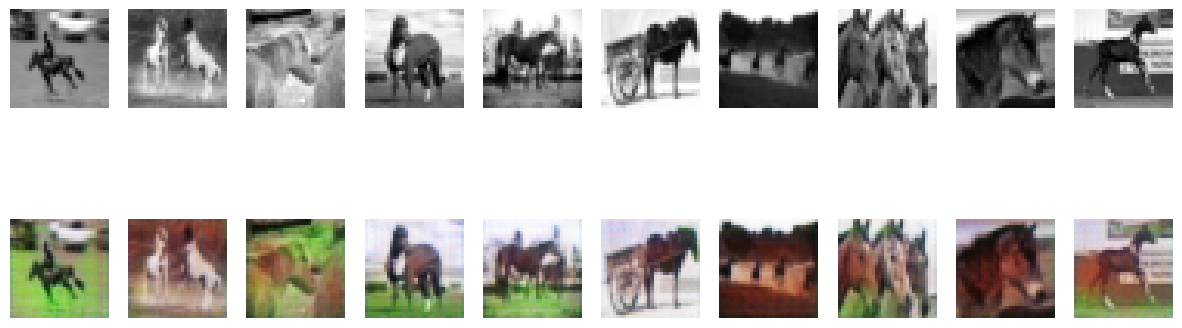

In [90]:
# Convert images to numpy arrays
gray_images = gray_images.cpu().detach().numpy()
visual_outputs = visual_outputs

# Correct image structure for visualization
gray_images = np.transpose(gray_images[:, :, :, :], (0, 2, 3, 1)).squeeze()
visual_outputs = np.transpose(visual_outputs[:, :, :, :], (0, 2, 3, 1))

# Plot images
plt.figure(figsize=(15, 5))
for i in range(10):
    # Grayscale input images (Row 1)
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(gray_images[i], cmap='gray')
    ax.axis("off")

    # Generated color images (Row 2)
    ax = plt.subplot(2, 10, i + 11)  # Adjusted index to second row
    ax.imshow(visual_outputs[i])  # No need for astype(np.uint8) here since it's already converted
    ax.axis("off")

plt.show()


Manually Check if the order matchecs

Keys in the NPZ file: ['arr_0']


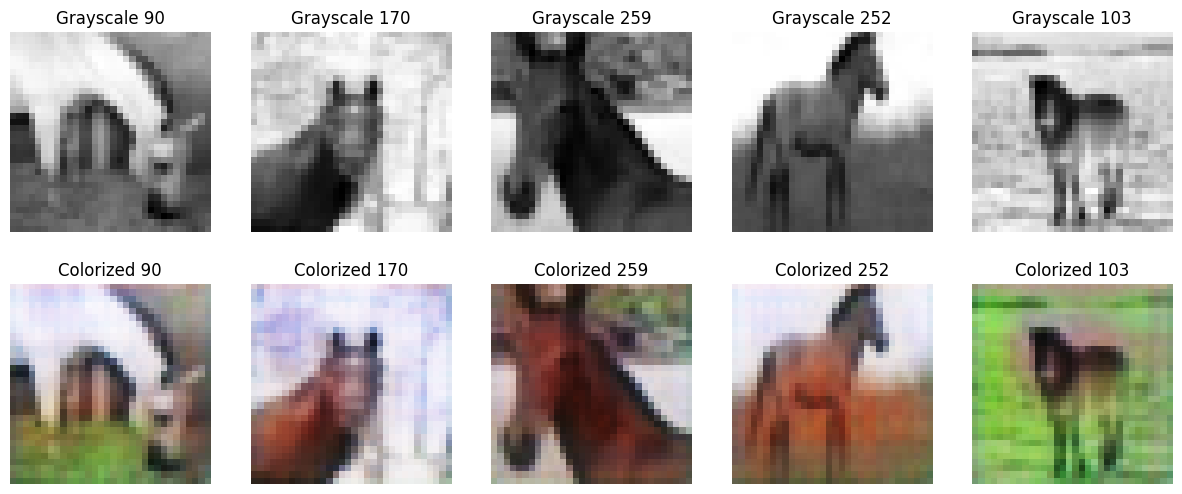

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Load the NPZ file
file_path = "colourized.npz"  # Change this to your actual file path
data = np.load(file_path)

# Check the keys stored in the NPZ file
print("Keys in the NPZ file:", list(data.keys()))

# Assuming the grayscale images and colorized images are stored separately
colorized_images = data['arr_0'].transpose(0,2,3,1)  # (B,H,W,C) for matplot

# Display a few images to check the order
num_images_to_show = 5
fig, axes = plt.subplots(2, num_images_to_show, figsize=(15, 6))

for i in range(num_images_to_show):
    random_order = np.random.randint(0, 275)

    # Load grayscale and colorized images
    grayscale_img = gray_images[i+random_order].squeeze()  # Ensure correct shape
    colorized_img = (colorized_images[i+random_order])/255  # Normalize if stored in [0, 255]

    # Display grayscale image
    axes[0, i].imshow(grayscale_img, cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Grayscale {i+random_order}")

    # Display Colorized Image
    axes[1, i].imshow(colorized_img)
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Colorized {i+random_order}")

plt.show()


### Part (ii) [2pt DISCUSSION]

Summarize the qualitative performance of your best model on image colourization of new data and provide some reasons why it performs the way it does. Are there certain types of images on which your model works better than on others? Explain.



In [102]:
'''
PROVIDE YOUR ANSWER BELOW

1. Strengths
- The model performs well on images with well-defined object boundaries and clear textures
- Horses with consistenet backgrounds (Open fields) are more accurately colorized
- General horses body colors appear natural in some images

2. Weakness
- The model struggles with complex backgrounds, leading to inconsistenet colorization
- Some iamges have blurry or distorted colors, particularly around edges
- Cases where multiple horses or unusual lighting are present lead to unnatural hues

3. Possible Reasons
- The dataset may have biases in colors
- The generator may focus more on global colorization but fail in fine details





'''

'\nPROVIDE YOUR ANSWER BELOW\n\n1. Strengths\n- The model performs well on images with well-defined object boundaries and clear textures\n- Horses with consistenet backgrounds (Open fields) are more accurately colorized\n- General horses body colors appear natural in some images\n\n2. Weakness\n- The model struggles with complex backgrounds, leading to inconsistenet colorization\n- Some iamges have blurry or distorted colors, particularly around edges\n- Cases where multiple horses or unusual lighting are present lead to unnatural hues\n\n3. Possible Reasons \n- The dataset may have biases in colors\n- The generator may focus more on global colorization but fail in fine details\n\n\n\n\n\n'

## Part 3 Exploration [6 Pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there are many other approaches we could take. In this part of the assignment you are asked to consider some modifications you could make to improve the results and provide some comments on why those approaches could be beneficial.

### Part (i) [2pt DISCUSSION]

We've seen several times in this course how pretrained models could be used to improve performance on classification tasks. Do you think they could be beneficial in improving our results on the image colourization tasks? If so, would it be helpful to implement them in the discriminative and/or generative networks? Why or why not?

Limit your answers to no more than 100 words.

In [3]:
'''
PROVIDE YOUR ANSWER BELOW

Pretrained models could help improve image colorization by providing feature extraction capabilities learned from large datasets.
This could benefit the discriminator by making it more robust in distinguishing real from fake images and improve the generator by learning high-level colorization patterns.
Implementing them in the discriminator could help it better differentiate between real and generated images
On the other hand using them in the generator (e.g., as a pretrained encoder) might accelerate training and lead to more realistic outputs.
However, domain differences between pretraining datasets and the target task could limit effectiveness.

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nPretrained models could help improve image colorization by providing feature extraction capabilities learned from large datasets. \nThis could benefit the discriminator by making it more robust in distinguishing real from fake images and improve the generator by learning high-level colorization patterns. \nImplementing them in the discriminator could help it better differentiate between real and generated images\nOn the other hand using them in the generator (e.g., as a pretrained encoder) might accelerate training and lead to more realistic outputs. \nHowever, domain differences between pretraining datasets and the target task could limit effectiveness.\n\n\n\n\n\n'

### Part (ii) [2pt DISCUSSION]
The CIFAR10 images are 32x32 pixels in resolution. Do you believe that using similar images with a resolution of 256x256 would lead to better results. Why or why not?

Limit your answers to no more than 100 words.

In [2]:
'''
PROVIDE YOUR ANSWER BELOW

Using higher-resolution images like 256×256 instead of 32×32 could improve image colorization quality, as more details and textures can be captured.
This would allow the model to learn more meaningful relationships between grayscale and color.
However, higher resolutions also increase computational cost, requiring more memory and longer training times.
If the dataset is small, a higher resolution may not provide significant improvements due to limited training examples.
The benefit depends on the dataset size, network capacity, and the ability to scale up the model efficiently.

'''


'\nPROVIDE YOUR ANSWER BELOW\n\nUsing higher-resolution images like 256×256 instead of 32×32 could improve image colorization quality, as more details and textures can be captured. \nThis would allow the model to learn more meaningful relationships between grayscale and color. \nHowever, higher resolutions also increase computational cost, requiring more memory and longer training times. \nIf the dataset is small, a higher resolution may not provide significant improvements due to limited training examples. \nThe benefit depends on the dataset size, network capacity, and the ability to scale up the model efficiently.\n\n'

### Part (iii) [2pt DISCUSSION]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Limit your answers to no more than 100 words.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

The RGB color space is not perceptually uniform, meaning that the Euclidean distance between two colors in RGB does not always match how humans perceive color differences.
For example, small numerical differences in RGB values can lead to large perceptual differences, and vice versa.
Additionally, RGB does not separate luminance from chrominance, making colorization harder for models to learn.
Instead, many state-of-the-art colorization models use CIELAB or YUV color spaces, where color differences align more closely with human perception.
These spaces allow models to focus on learning chrominance while preserving luminance, improving both the accuracy and realism of colorized images.

Reference: http://www.cs.harvard.edu/~sjg/papers/cspace.pdf

'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the concepts introduced in the assignment.

In Part A we constructed an autoencoder, specifically a UNet architecture with skip connections to learn to colourize images. In Part B completed the same task using conditional GANs. For this bonus challenge we will explore several other techniques that could be used to improve the model's performance on image colourization. A great tutorial on some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>. It is highly recommended that you read the article before completing the following tasks:

Tasks:

1. Modify your conditional GAN architecture to incorporate a pretrained ResNet model to speed up and improve the generative abilities for image colourization.
2. Modify your conditional GAN architecture to incorporate the patch discriminator trained on local regions in the images.
3. Modify your conditional GAN architecture to use higher resolution images of upto 256 x 256 resolution and compare the performance. Summarize how performance changes with increasing resolution of images. Hint: for this task you will need to use another dataset, perhaps COCO, or ImageNet.
4. Modify your conditional GAN architecture to incorporate lab colour space image data representation instead of RGB data. Compare the performance of your model using RGB vs lab colour space data.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

In [ ]:
# TO BE COMPLETED







In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html /content/A3.ipynb

(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **5 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**